## Steel Defect Detection

In this notebook I will focus on implementing a ResUNet architecture to predict the location and type of defects found on a steel surface during manufacturing

Data-set : https://www.kaggle.com/c/severstal-steel-defect-detection

## Import Packages

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split 
import cv2
import tensorflow as tf

### Simple EDA 

In [2]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("sample_submission.csv")

train_df.shape

(7095, 3)

In [3]:
train_df.head()

,ImageId,ClassId,EncodedPixels
0,0002cc93b.jpg,1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg,3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg,1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg,4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg,3,229501 11 229741 33 229981 55 230221 77 230468...


In [4]:
defect_type =  train_df.ClassId.value_counts()
defect_type

3    5150
1     897
4     801
2     247
Name: ClassId, dtype: int64

In [5]:
# Add a new column for the defect 
train_df['Defect'] = train_df['ClassId'].apply(lambda x:1)
defect = train_df.groupby(['ImageId'])['Defect'].sum()
defects = defect.value_counts()
defects

1    6239
2     425
3       2
Name: Defect, dtype: int64

Images with atleast one defect: 6666
Total number of defects: 7095


Text(0, 0.5, 'Number of images')

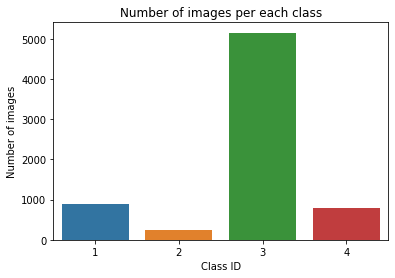

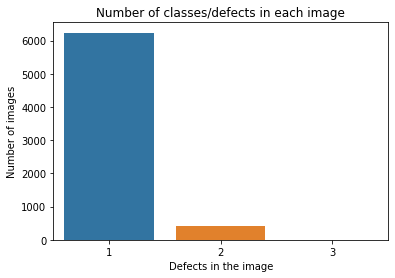

In [6]:
print('Images with atleast one defect: %s' % sum(defects))
print('Total number of defects: %s' % len(train_df['Defect']))

# Plot the Defects wrt to each image and vice versa

fig, ax = plt.subplots()
sns.barplot(x=defect_type.index, y=defect_type, ax=ax)
ax.set_title("Number of images per each class");
ax.set_xlabel("Class ID")
ax.set_ylabel("Number of images")

fig, ax = plt.subplots()
sns.barplot(x=defects.index, y=defects, ax=ax)
ax.set_title("Number of classes/defects in each image");
ax.set_xlabel("Defects in the image")
ax.set_ylabel("Number of images")



In [7]:
train_dir = 'Dataset/train_images'
no_defect = []
for i in os.listdir(train_dir):
    if i not in list(train_df.ImageId):
        no_defect.append(i)

print('Total number of images in training directory: %s' % len(os.listdir(train_dir)))
print('Total number of images with no defect: %s' % len(no_defect))

Total number of images in training directory: 12568
Total number of images with no defect: 5902


#### Dataframe Creation containing both the defect and non defect steel images

In [8]:
Image_id = [i for i in train_df.ImageId]

for i in no_defect:
    Image_id.append(i)
    
# Creating labels label '0' - no defect & '1' - defect
label = [1 for i in train_df.ImageId]
for i in no_defect:
    label.append(0)

df = pd.DataFrame({'ImageID': Image_id, 'label': label})
df.head()

,ImageID,label
0,0002cc93b.jpg,1
1,0007a71bf.jpg,1
2,000a4bcdd.jpg,1
3,000f6bf48.jpg,1
4,0014fce06.jpg,1


In [9]:
print(df.shape)
df.label.value_counts()

(12997, 2)


1    7095
0    5902
Name: label, dtype: int64